## 0. 필요한 모듈 불러오기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import cv2
from PIL import Image
%matplotlib inline

print(Image.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(cv2.__version__)

7.2.0
1.19.0
3.2.2
4.3.0


## 1. 함수 정의

이미지 가져오는 함수

In [2]:
def load_image(img_path):
    _im = Image.open(img_path)
    _im = np.array(_im)/255
    _obj = _im[:, :, 3]
    _area = (_obj > 0).sum()
    return _im, _obj, _area

객체를 탐지하는 재귀함수

In [3]:
def quadtree_search(min_x, max_x, min_y, max_y, current_x, current_y, level, index):
    _x, _y = current_x, current_y
    if max_x < current_x:
        return _
    elif (min_x <= current_x <= max_x) and not (min_y <= current_y <= max_y):
        _y = min_y
        if min_y < current_y:
            _x += 1
    elif current_x < min_x:
        _x, _y = min_x, min_y
        
    for i in range(_x, max_x + 1):
        for j in range(_y, max_y + 1):
            if obj[j][i] != 0:
                quadtree[index] = 1
                if setting_level > level:
                    _half_x, _half_y = int((max_x - min_x + 1) / 2), int((max_y - min_y + 1) / 2)
                    quadtree_search(min_x, min_x + _half_x - 1, min_y, min_y + _half_y - 1, i, j, level + 1, index * 4 + 1)
                    quadtree_search(min_x + _half_x, max_x, min_y, min_y + _half_y - 1, i, j, level + 1, index * 4 + 2)
                    quadtree_search(min_x, min_x + _half_x - 1, min_y + _half_y, max_y, i, j, level + 1, index * 4 + 3)
                    quadtree_search(min_x + _half_x, max_x, min_y + _half_y, max_y, i, j, level + 1, index * 4 + 4)
                return _

(비교용) 면적을 전부 탐색하는 함수

In [4]:
def normal_search(max_x, max_y):
    for i in range(max_x + 1):
        for j in range(max_y + 1):
            if obj[j][i] != 0:
                obj[j][i] = obj[j][i]

쿼드트리를 바탕으로 객체를 그리는 함수

In [5]:
def draw_from_tree(min_x, max_x, min_y, max_y, level, index):
    _approx_obj = np.ones((512, 512, 3))
    if quadtree[index] == 0:
        if index == 0:
            return _approx_obj
        elif index > 0:
            return []
    elif quadtree[index] == 1:
        if setting_level == level:
            return [(min_x, max_x, min_y, max_y)]
        elif setting_level > level:
            _half_x, _half_y = int((max_x - min_x + 1) / 2), int((max_y - min_y + 1) / 2)
            _coor = (
                draw_from_tree(min_x, min_x + _half_x - 1, min_y, min_y + _half_y - 1, level + 1, index * 4 + 1) +
                draw_from_tree(min_x + _half_x, max_x, min_y, min_y + _half_y - 1, level + 1, index * 4 + 2) +
                draw_from_tree(min_x, min_x + _half_x - 1, min_y + _half_y, max_y, level + 1, index * 4 + 3) +
                draw_from_tree(min_x + _half_x, max_x, min_y + _half_y, max_y, level + 1, index * 4 + 4)
            )
            if index > 0:
                return _coor
            elif index == 0:
                for i in _coor:
                    _min_x, _max_x, _min_y, _max_y = i
                    _approx_obj = cv2.rectangle(_approx_obj, (_min_x, _min_y), (_max_x, _max_y), (0., 0., 0.), -1)
                return _approx_obj

면적을 계산하는 재귀함수

In [6]:
def calc_area(level, index, x, y):
    if quadtree[index] == 0:
        return 0
    elif quadtree[index] == 1:
        if setting_level == level:
            _approx_area = int(x/2**(level-1)) * int(y/2**(level-1))
            return _approx_area
        elif setting_level > level:
            _approx_area = (
                calc_area(level + 1, index * 4 + 1, x, y)
                + calc_area(level + 1, index * 4 + 2, x, y)
                + calc_area(level + 1, index * 4 + 3, x, y)
                + calc_area(level + 1, index * 4 + 4, x, y)
            )
            return _approx_area

## 2. 실행

사용자 설정값

(1365,)
(512, 512, 4) (512, 512)


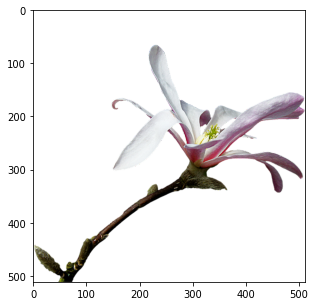

In [7]:
setting_level = 6
img_path = './test_images/test_image_06.png'

quadtree = np.zeros(sum([4**x for x in range(setting_level)]))
print(quadtree.shape)

plt.figure(figsize=(5, 5))
im, obj, area = load_image(img_path)
print(im.shape, obj.shape)
plt.imshow(im)
plt.show()

In [8]:
start = time.time()
quadtree_search(0, 511, 0 ,511, 0, 0, 1, 0)
print('연산 시간:', time.time() - start)

start = time.time()
normal_search(511, 511)
print('연산 시간:', time.time() - start)

print(quadtree)

연산 시간: 0.11584901809692383
연산 시간: 0.16611075401306152
[1. 1. 1. ... 0. 0. 0.]


In [9]:
approx_area = calc_area(1, 0, 512, 512)
print(area, approx_area)

40841 68864


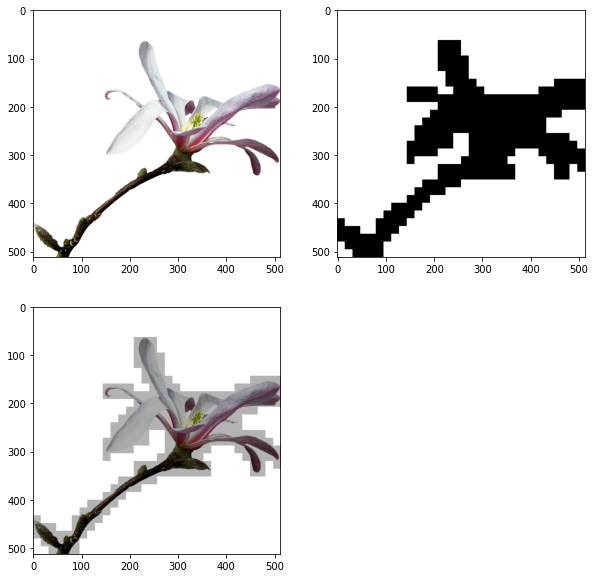

In [10]:
approx_obj = draw_from_tree(0, 511, 0, 511, 1, 0)

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(im)

plt.subplot(222)
plt.imshow(approx_obj)

plt.subplot(223)
plt.imshow(im)
plt.imshow(approx_obj, alpha=0.3)

plt.show()